<a href="https://colab.research.google.com/github/andreadosi1986/andreadosi/blob/master/ProgettoCariocaDlRun3SingValuesKFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul  6 17:04:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from matplotlib import rc
import skimage
from skimage.measure import regionprops
import random
import pandas as pd
from skimage import filters
import tifffile as tiff
import tensorflow as tf
import keras
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
### IMPORT TRAINING TEST SET AND CORRISPONDING LABELLING ####

In [ ]:
X_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train4classes3SingVal.npy')

In [ ]:
X_test = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_test4classes3SingVal.npy')
y_train_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_cat4classes3SingVal.npy')
y_test_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_test_cat4classes3SingVal.npy')

In [ ]:
y_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train4classes3SingVal.npy')
y_test = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_test4classes3SingVal.npy')

In [ ]:
#calulate the proporcion of the different categories
Y2 = np.concatenate((y_train, y_test))
print(Y2.shape)

(5226, 128, 128, 1)


In [ ]:
#print(np.unique(Y2))
bkground_class = len(Y2[Y2==0])/(5226*128*128)
mining_class = len(Y2[Y2==1])/(5226*128*128)
veg_class = len(Y2[Y2==2])/(5226*128*128)
sea_class = len(Y2[Y2==3])/(5226*128*128)

print(bkground_class, mining_class, veg_class, sea_class)

0.08407398899806855 0.02660340967189294 0.6152103510205882 0.27411225030945036


In [ ]:
0.08407398899806855 + 0.02660340967189294 + 0.6152103510205882 + 0.27411225030945036

1.0

In [ ]:
print(X_train.shape, X_test.shape, y_train_cat.shape, y_test_cat.shape)

(4180, 128, 128, 3) (1046, 128, 128, 3) (4180, 128, 128, 4) (1046, 128, 128, 4)


In [ ]:
#concatenation for the k-fold
X = np.concatenate((X_train, X_test))
print(X.shape)

(5226, 128, 128, 3)


In [ ]:
#concatenation for the k-fold
Y = np.concatenate((y_train_cat, y_test_cat))
print(Y.shape)

In [ ]:
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/X_trainKFold', X)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/Y_trainKFold', Y)


In [ ]:
print(X_train.shape, X_test.shape, y_train_cat.shape, y_test_cat.shape)

(4180, 128, 128, 3) (1046, 128, 128, 3) (4180, 128, 128, 4) (1046, 128, 128, 4)


In [ ]:
#(np.argmax(y_train_cat[0], axis = 3))

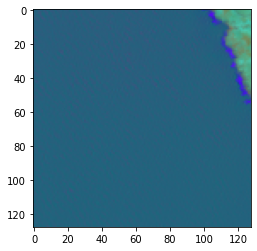

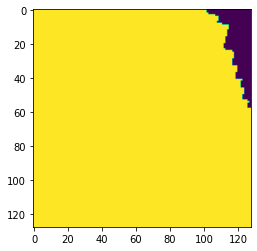

In [ ]:
#check if the concatenation is correct
import random
i = random.randint(0, 5226)
plt.imshow(X[i])
plt.show()


im = np.argmax(Y, axis = 3)
plt.imshow(im[i])
plt.show()

In [ ]:
#import segmentation_models as sm
#class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
#dice_loss = sm.losses.DiceLoss(class_weights=class_weight_array) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
#jaccard_loss = sm.losses.bce_jaccard_loss(class_weights=class_weight_array)

In [ ]:
#####################################################################################
############## restart kernel and run the libreries ################

X = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_trainKFold.npy')
Y = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/Y_trainKFold.npy')

In [ ]:
################################################################ U-NET BUILD ###########################################

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
IMG_HEIGHT = X.shape[1]
IMG_WIDTH  = X.shape[2]
IMG_CHANNELS = X.shape[3]
n_classes=4

In [ ]:
#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
#model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
#model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
#model.summary()

In [ ]:

#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()
monitor = EarlyStopping(monitor= 'val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
'''
## build the call back
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
'''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''
'''
    # Check accuracy
    if(logs.get('accuracy') > 0.99):

      # Stop if threshold is met
      print("\nAccuracy is more than than 0.99 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()
'''

'\n    # Check accuracy\n    if(logs.get(\'accuracy\') > 0.99):\n\n      # Stop if threshold is met\n      print("\nAccuracy is more than than 0.99 so cancelling training!")\n      self.model.stop_training = True\n\n# Instantiate class\ncallbacks = myCallback()\n'

In [ ]:
import time
start = time.time()
### fit the deep learning model with 5 k-fold cross validation
from sklearn.model_selection import KFold

n_split=5
train_acc_lst_max = []
val_acc_ls_max = []
train_acc_lst = []
val_acc_lst = []

i = 0
for train_index,test_index in KFold(n_split).split(X):
  i = i+1
  checkpointer= ModelCheckpoint(filepath="/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEp4Classes3ChannelsWithNoise"+"experiment"+str(i)+".hdf5", 
                                verbose = 0, save_best_only = True) 
  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index]
  np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/x_testK'+str(i), x_test)
  np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/y_testK'+str(i), y_test)
  history = model.fit(x_train, y_train, 
                      verbose=1, 
                      epochs=100, 
                      validation_data=(x_test, y_test),
                    #sample_weight=class_weight_array,
                      shuffle=False,
                      callbacks=[monitor, checkpointer]
                      )
  print(i)

  #accuracy for each k-fold
  acc_max = np.max(np.array(history.history['accuracy']))
  val_acc_max = np.max(np.array(history.history['val_accuracy']))
  train_acc_lst_max.append(acc_max)
  val_acc_ls_max.append(val_acc_max)
  train_acc_lst.append(history.history['accuracy'])
  val_acc_lst.append(history.history['val_accuracy'])

  


print("Total model fit time: ", time.time() - start, "seconds")

Epoch 1/100
131/131 [==============================] - 20s 110ms/step - loss: 0.5185 - accuracy: 0.8138 - val_loss: 0.3370 - val_accuracy: 0.8825
Epoch 2/100
131/131 [==============================] - 12s 89ms/step - loss: 0.2642 - accuracy: 0.9020 - val_loss: 0.1843 - val_accuracy: 0.9345
Epoch 3/100
131/131 [==============================] - 12s 90ms/step - loss: 0.1534 - accuracy: 0.9425 - val_loss: 0.1294 - val_accuracy: 0.9519
Epoch 4/100
131/131 [==============================] - 12s 89ms/step - loss: 0.1151 - accuracy: 0.9551 - val_loss: 0.1003 - val_accuracy: 0.9612
Epoch 5/100
131/131 [==============================] - 12s 89ms/step - loss: 0.0944 - accuracy: 0.9622 - val_loss: 0.0834 - val_accuracy: 0.9666
Epoch 6/100
131/131 [==============================] - 12s 89ms/step - loss: 0.0813 - accuracy: 0.9668 - val_loss: 0.0782 - val_accuracy: 0.9687
Epoch 7/100
131/131 [==============================] - 12s 90ms/step - loss: 0.0765 - accuracy: 0.9686 - val_loss: 0.0738 - val_a

In [ ]:
model_saved1 =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEp4Classes3ChannelsWithNoiseexperiment1.hdf5',compile=False)
model_saved2 =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEp4Classes3ChannelsWithNoiseexperiment2.hdf5',compile=False)
model_saved3 =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEp4Classes3ChannelsWithNoiseexperiment3.hdf5',compile=False)
model_saved4 =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEp4Classes3ChannelsWithNoiseexperiment4.hdf5',compile=False)
model_saved5 =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNetEarlyStopEp4Classes3ChannelsWithNoiseexperiment5.hdf5',compile=False)


In [ ]:
print(train_acc_lst)
print(val_acc_lst)
print(val_acc_ls_max)
print(train_acc_lst_max)
print(len(train_acc_lst))
arr_acc = np.array(train_acc_lst, dtype=object)
val_acc = np.array(val_acc_lst, dtype=object)
val_acc_max = np.array(val_acc_ls_max, dtype=object)
train_acc_max = np.array(train_acc_lst_max, dtype=object)

[[0.813819169998169, 0.9019848704338074, 0.9425126314163208, 0.9550502300262451, 0.9621636271476746, 0.9667649865150452, 0.9686316847801208, 0.9711267948150635, 0.9734399914741516, 0.9739089608192444, 0.9757698178291321, 0.976513147354126, 0.9776166081428528, 0.9784793853759766, 0.9790877103805542, 0.9789121747016907, 0.9799180626869202, 0.9800713658332825, 0.98024982213974, 0.9812607765197754, 0.9818263649940491, 0.9817821979522705, 0.9824895262718201, 0.9215176105499268, 0.9601954817771912, 0.9713160395622253, 0.9754289984703064], [0.9761310815811157, 0.9781054854393005, 0.9793056845664978, 0.9801611304283142, 0.9807983040809631, 0.9814438819885254, 0.981717050075531, 0.9822356104850769, 0.9826637506484985, 0.9829856157302856, 0.9833206534385681, 0.9836107492446899, 0.9838066101074219, 0.9840441346168518, 0.9842472076416016, 0.9843317866325378, 0.9847183227539062, 0.9849367141723633, 0.9850577116012573, 0.9851553440093994, 0.9852631688117981], [0.9846240878105164, 0.9849585890769958,

In [ ]:
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/train_acc_lst', arr_acc)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/val_acc_lst', val_acc)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/val_acc_ls_max', val_acc_max)
np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/train_acc_lst_max', train_acc_max)

In [ ]:
temp_array = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/train_acc_lst.npy', allow_pickle=True)
print(temp_array.shape, type(temp_array))

(5,) <class 'numpy.ndarray'>


In [ ]:
#model_saved1.history['val_accuracy']

In [ ]:
#train_acc = np.array(train_acc_lst)
test_acc = np.array(val_acc_ls_max)
test_acc_mean = np.mean(val_acc_ls_max)
#test_acc_mean = np.mean(test_acc)
test_acc_std = np.std(test_acc)
#test_acc_std = np.std(test_acc)


In [ ]:
#the mean and std of the k=5 models
print(test_acc_mean, test_acc_std)


0.9896990180015564 0.0018886511584383211


In [ ]:
#model_saved =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_200Ep4Classes3ChannelsWithNoise',compile=False)


In [ ]:
#minutes_fit_time =(2456.1134254932404)/60
#print(minutes_fit_time, "minutes")

In [ ]:
#loss = history.history['loss']
#val_loss = history.history['val_loss']
#epochs = range(1, len(loss) + 1)
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#plt.plot(epochs, acc, 'b', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
#plt.title('Training and validation Accuracy balanced model')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Sardinia/Accuracy.png", bbox_inches='tight')

#plt.show()

In [ ]:
#plot the training and validation accuracy and loss at each epoch
#loss = history.history['loss']
#val_loss = history.history['val_loss']
#epochs = range(1, len(loss) + 1)
#plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
#plt.title('Training and validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Sardinia/LossFunction.png", bbox_inches='tight')
#plt.show()

In [ ]:
#label_masks={0 : "background",1 : 'sea', 2 : "vegetation", 3 : "miner"} 

In [ ]:
#prediction = model.predict(X_test)

In [ ]:
#prediction.shape

In [ ]:
#predicted_img=np.argmax(prediction, axis=3)[45,:,:]

In [ ]:
#predicted_img.shape

In [ ]:
#from re import I
#from random import randint
#i = randint(0, 1046)
#predicted_img=np.argmax(prediction, axis=3)[i,:,:]
#print("PREDICTION")
#plt.imshow(predicted_img)
#plt.show()
#print(np.unique(predicted_img))
#print("GROUND TRUTH")
#plt.imshow(y_test[i,:,:,0])
#plt.show()
#print(np.unique(y_test[i,:,:,0]))

In [ ]:
x_test1 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/x_testK1.npy')
y_test1 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_testK1.npy')

In [ ]:
x_test2 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/x_testK2.npy')
y_test2 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_testK2.npy')

x_test3 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/x_testK3.npy')
y_test3 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_testK3.npy')

x_test4 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/x_testK4.npy')
y_test4 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_testK4.npy')

In [ ]:
x_test5 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/x_testK5.npy')
y_test5 = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_testK5.npy')

In [ ]:
####### CONFUSION MATRIX ########
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

pred1 = model_saved1.predict(x_test1)
pred1 = np.argmax(pred1, axis = 3)
y_test1 = np.argmax(y_test1, axis = 3)

In [ ]:
pred2 = model_saved2.predict(x_test2)
pred2 = np.argmax(pred2, axis = 3)
y_test2 = np.argmax(y_test2, axis = 3)

pred3 = model_saved3.predict(x_test3)
pred3 = np.argmax(pred3, axis = 3)
y_test3 = np.argmax(y_test3, axis = 3)

pred4 = model_saved4.predict(x_test4)
pred4 = np.argmax(pred4, axis = 3)
y_test4 = np.argmax(y_test4, axis = 3)

pred5 = model_saved5.predict(x_test5)
pred5 = np.argmax(pred5, axis = 3)
y_test5 = np.argmax(y_test5, axis = 3)

In [ ]:
print(y_test1.shape, pred1.shape, np.unique(y_test1), np.unique(pred1))

(1046, 128, 128) (1046, 128, 128) [0 1 2 3] [0 1 2 3]


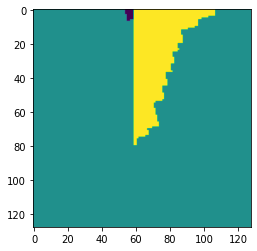

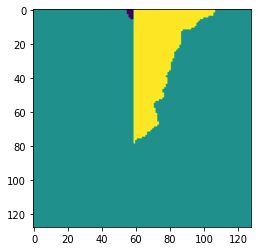

In [ ]:
plt.imshow(y_test1[0])
plt.show()

plt.imshow(pred1[0])
plt.show()

In [ ]:
##### ALGORITHM TO CALCULATE TRUE POSITIVE AND TRUE NEGATIVE #####
y_test1_bin = np.where(y_test1 ==1, 1,0)
pred1_bin =  np.where(pred1 ==1, 1,0)

In [ ]:
y_test2_bin = np.where(y_test2 ==1, 1,0)
pred2_bin =  np.where(pred2 ==1, 1,0)

y_test3_bin = np.where(y_test3 ==1, 1,0)
pred3_bin =  np.where(pred3 ==1, 1,0)

y_test4_bin = np.where(y_test4 ==1, 1,0)
pred4_bin =  np.where(pred4 ==1, 1,0)

y_test5_bin = np.where(y_test5 ==1, 1,0)
pred5_bin =  np.where(pred5 ==1, 1,0)

In [ ]:
print(y_test1_bin.shape, np.unique(y_test1_bin), pred1_bin.shape, np.unique(pred1_bin))

(1046, 128, 128) [0 1] (1046, 128, 128) [0 1]


In [ ]:
############ K = 1 #############
tp = 0 
tn = 0 
fp = 0 
fn = 0
for i in range (pred1_bin.shape[0]):
  for j in range (pred1_bin.shape[1]):
    for k in range (pred1_bin.shape[2]):
      if ((pred1_bin[i,j,k] - y_test1_bin[i,j,k]==0) and (pred1_bin[i,j,k] == 1 and y_test1_bin[i,j,k]==1)):
        tp = tp +1
      elif ((pred1_bin[i,j,k] - y_test1_bin[i,j,k]==0) and (pred1_bin[i,j,k] == 0 and y_test1_bin[i,j,k]==0)):
        tn = tn +1
      elif (pred1_bin[i,j,k] - y_test1_bin[i,j,k]>0):
        fp = fp +1
      elif (pred1_bin[i,j,k] - y_test1_bin[i,j,k]<0):
        fn = fn +1
print(tp, tn, fp, fn)


434744 16658678 17432 26810


In [ ]:
tp_norm1 = tp / np.count_nonzero(y_test1_bin)
tn_norm1 = tn / ((1046*128*128)-np.count_nonzero(y_test1_bin))
fp_norm1 = fp / np.count_nonzero(y_test1_bin)
fn_norm1 = fn / ((1046*128*128)-np.count_nonzero(y_test1_bin))
print(tp_norm1, tn_norm1, fp_norm1, fn_norm1)
conf_mtrx1 = np.array([[tp_norm1, fn_norm1], [fp_norm1, tn_norm1]])
print(conf_mtrx1, conf_mtrx1.shape)

0.9419136222413845 0.9989546722826846 0.03776806180858578 0.0016076890833653652
[[0.94191362 0.00160769]
 [0.03776806 0.99895467]] (2, 2)


16676110

In [ ]:
############ K = 2 #############
tp = 0 
tn = 0 
fp = 0 
fn = 0
for i in range (pred2_bin.shape[0]):
  for j in range (pred2_bin.shape[1]):
    for k in range (pred2_bin.shape[2]):
      if ((pred2_bin[i,j,k] - y_test2_bin[i,j,k]==0) and (pred2_bin[i,j,k] == 1 and y_test2_bin[i,j,k]==1)):
        tp = tp +1
      elif ((pred2_bin[i,j,k] - y_test2_bin[i,j,k]==0) and (pred2_bin[i,j,k] == 0 and y_test2_bin[i,j,k]==0)):
        tn = tn +1
      elif (pred2_bin[i,j,k] - y_test2_bin[i,j,k]>0):
        fp = fp +1
      elif (pred2_bin[i,j,k] - y_test2_bin[i,j,k]<0):
        fn = fn +1
print(tp, tn, fp, fn)

In [ ]:
tp_norm2 = tp / np.count_nonzero((y_test2_bin))
tn_norm2 = tn / ((1046*128*128)-np.count_nonzero(y_test2_bin))
fp_norm2 = fp / np.count_nonzero((y_test2_bin))
fn_norm2 = fn / ((1046*128*128)-np.count_nonzero(y_test2_bin))
print(tp_norm2, tn_norm2, fp_norm2, fn_norm2)
conf_mtrx2 = np.array([[tp_norm2, fn_norm2], [fp_norm2, tn_norm2]])
print(conf_mtrx2, conf_mtrx2.shape)

1.0203106522695116 0.9966317301843769 0.02566971151764821 0.0011786489085640443
[[1.02031065 0.00117865]
 [0.02566971 0.99663173]] (2, 2)


In [ ]:
############ K = 3 #############
tp = 0 
tn = 0 
fp = 0 
fn = 0
for i in range (pred3_bin.shape[0]):
  for j in range (pred3_bin.shape[1]):
    for k in range (pred3_bin.shape[2]):
      if ((pred3_bin[i,j,k] - y_test3_bin[i,j,k]==0) and (pred3_bin[i,j,k] == 1 and y_test3_bin[i,j,k]==1)):
        tp = tp +1
      elif ((pred3_bin[i,j,k] - y_test3_bin[i,j,k]==0) and (pred3_bin[i,j,k] == 0 and y_test3_bin[i,j,k]==0)):
        tn = tn +1
      elif (pred3_bin[i,j,k] - y_test3_bin[i,j,k]>0):
        fp = fp +1
      elif (pred3_bin[i,j,k] - y_test3_bin[i,j,k]<0):
        fn = fn +1
print(tp, tn, fp, fn)

447797 16642535 11266 19682


In [ ]:
tp_norm3 = tp / np.count_nonzero((y_test3_bin))
tn_norm3 = tn / ((1046*128*128)-np.count_nonzero(y_test3_bin))
fp_norm3 = fp / np.count_nonzero((y_test3_bin))
fn_norm3 = fn /((1046*128*128)-np.count_nonzero(y_test3_bin))
print(tp_norm3, tn_norm3, fp_norm3, fn_norm3)
conf_mtrx3 = np.array([[tp_norm3, fn_norm3], [fp_norm3, tn_norm3]])
print(conf_mtrx3, conf_mtrx3.shape)

0.957897574008672 0.9983413501409852 0.024099478265333842 0.001180670760402479
[[0.95789757 0.00118067]
 [0.02409948 0.99834135]] (2, 2)


In [ ]:
############ K = 4 #############
tp = 0 
tn = 0 
fp = 0 
fn = 0
for i in range (pred4_bin.shape[0]):
  for j in range (pred4_bin.shape[1]):
    for k in range (pred4_bin.shape[2]):
      if ((pred4_bin[i,j,k] - y_test4_bin[i,j,k]==0) and (pred4_bin[i,j,k] == 1 and y_test4_bin[i,j,k]==1)):
        tp = tp +1
      elif ((pred4_bin[i,j,k] - y_test4_bin[i,j,k]==0) and (pred4_bin[i,j,k] == 0 and y_test4_bin[i,j,k]==0)):
        tn = tn +1
      elif (pred4_bin[i,j,k] - y_test4_bin[i,j,k]>0):
        fp = fp +1
      elif (pred4_bin[i,j,k] - y_test4_bin[i,j,k]<0):
        fn = fn +1
print(tp, tn, fp, fn)

437657 16639316 28051 16256


In [ ]:
tp_norm4 = tp / np.count_nonzero((y_test4_bin))
tn_norm4 = tn / ((1046*128*128)-np.count_nonzero(y_test4_bin))
fp_norm4 = fp / np.count_nonzero((y_test4_bin))
fn_norm4 = fn / ((1046*128*128)-np.count_nonzero(y_test4_bin))
print(tp_norm4, tn_norm4, fp_norm4, fn_norm4)
conf_mtrx4 = np.array([[tp_norm4, fn_norm4], [fp_norm4, tn_norm4]])
print(conf_mtrx4, conf_mtrx4.shape)

0.9641869697497097 0.9973366301139354 0.06179818599599483 0.0009743612212865081
[[9.64186970e-01 9.74361221e-04]
 [6.17981860e-02 9.97336630e-01]] (2, 2)


In [ ]:
############ K = 5 #############
tp = 0 
tn = 0 
fp = 0 
fn = 0
for i in range (pred5_bin.shape[0]):
  for j in range (pred5_bin.shape[1]):
    for k in range (pred5_bin.shape[2]):
      if ((pred5_bin[i,j,k] - y_test5_bin[i,j,k]==0) and (pred5_bin[i,j,k] == 1 and y_test5_bin[i,j,k]==1)):
        tp = tp +1
      elif ((pred5_bin[i,j,k] - y_test5_bin[i,j,k]==0) and (pred5_bin[i,j,k] == 0 and y_test5_bin[i,j,k]==0)):
        tn = tn +1
      elif (pred5_bin[i,j,k] - y_test5_bin[i,j,k]>0):
        fp = fp +1
      elif (pred5_bin[i,j,k] - y_test5_bin[i,j,k]<0):
        fn = fn +1
print(tp, tn, fp, fn)

440975 16649284 15967 15054


In [ ]:
tp_norm5 = tp / np.count_nonzero((y_test5_bin))
tn_norm5 = tn / ((1046*128*128)-np.count_nonzero(y_test5_bin))
fp_norm5 = fp / np.count_nonzero((y_test5_bin))
fn_norm5 = fn / ((1046*128*128)-np.count_nonzero(y_test5_bin))
print(tp_norm5, tn_norm5, fp_norm5, fn_norm5)
conf_mtrx5 = np.array([[tp_norm5, fn_norm5], [fp_norm5, tn_norm5]])
print(conf_mtrx5, conf_mtrx5.shape)

0.9669889414927559 0.9980606817017637 0.03501312416534914 0.0009024295280408665
[[9.66988941e-01 9.02429528e-04]
 [3.50131242e-02 9.98060682e-01]] (2, 2)


In [ ]:
tp_norm_mean = np.mean([tp_norm1, tp_norm2, tp_norm3, tp_norm4, tp_norm5])
tn_norm_mean = np.mean([tn_norm1, tn_norm2, tn_norm3, tn_norm4, tn_norm5])
fp_norm_mean = np.mean([fp_norm1, fp_norm2, fp_norm3, fp_norm4, fp_norm5])
fn_norm_mean = np.mean([fn_norm1, fn_norm2, fn_norm3, fn_norm4, fn_norm5])

tp_norm_std = np.std([tp_norm1, tp_norm2, tp_norm3, tp_norm4, tp_norm5])
tn_norm_std = np.std([tn_norm1, tn_norm2, tn_norm3, tn_norm4, tn_norm5])
fp_norm_std = np.std([fp_norm1, fp_norm2, fp_norm3, fp_norm4, fp_norm5])
fn_norm_std = np.std([fn_norm1, fn_norm2, fn_norm3, fn_norm4, fn_norm5])



In [ ]:
conf_mtrx_mean = np.array([[tp_norm_mean, fn_norm_mean], [fp_norm_mean, tn_norm_mean]])
print(conf_mtrx_mean, conf_mtrx_mean.shape)
conf_mtrx_std = np.array([[tp_norm_std, fn_norm_std], [fp_norm_std, tn_norm_std]])
print(conf_mtrx_std, conf_mtrx_std.shape)

[[0.97025955 0.0011275 ]
 [0.04440945 0.99786501]] (2, 2)
[[0.02649149 0.0002572 ]
 [0.01475339 0.00080656]] (2, 2)


In [ ]:
#np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/conf_mtrx_mean', conf_mtrx_mean)
#np.save('/content/drive/MyDrive/datamining/prisma/Sardinia/conf_mtrx_std', conf_mtrx_std)
conf_mtrx_mean = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/conf_mtrx_mean.npy')
conf_mtrx_std = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/conf_mtrx_std.npy')

In [ ]:
######## PRECISION RECALL ######
#precision = tp/(tp + fp)
#recall = tp/(tp + fn)
#dq = sqrt((dq/dx * dx)^^2 + (dq/dy * dy)^^2)
std_precision = (conf_mtrx_mean[0,0]/((conf_mtrx_mean[0,0] + conf_mtrx_mean[1,0])**2) * conf_mtrx_std[0,0] + 
                 conf_mtrx_std[0,0] * conf_mtrx_std[1,0])

std_recall = (conf_mtrx_mean[0,0]/((conf_mtrx_mean[0,0] + conf_mtrx_mean[0,1])**2) * conf_mtrx_std[0,0] + 
                 conf_mtrx_std[0,0] * conf_mtrx_std[0,1])


In [ ]:
print(std_precision, std_recall)

0.02535664437760407 0.027246979220404702


In [ ]:
precision = conf_mtrx_mean[0,0]/ (conf_mtrx_mean[0,0] + conf_mtrx_mean[1,0])
recall = conf_mtrx_mean[0,0]/ (conf_mtrx_mean[0,0] + conf_mtrx_mean[0,1])

print(precision, recall)

0.9562325707785361 0.9988392906899751


In [ ]:
#precision and recall are close to 1. It means that there are few false positive and negative